# imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import jeans

# data exploration

In [3]:
path = os.getcwd() + '/data/Rotmod_LTG/'

In [4]:
filename = path + 'CamB_rotmod.dat'
data = np.loadtxt(filename)

print(data)

[[ 0.16  1.99  1.5   1.86  3.75  0.   30.32  0.  ]
 [ 0.41  4.84  1.5   4.24  9.47  0.   23.77  0.  ]
 [ 0.57  6.79  1.5   5.61 11.76  0.   15.87  0.  ]
 [ 0.73  8.87  1.5   6.77 13.72  0.   12.4   0.  ]
 [ 0.9  10.9   1.5   7.77 14.8   0.    9.63  0.  ]
 [ 1.06 12.9   1.5   8.44 15.24  0.    5.86  0.  ]
 [ 1.22 14.7   1.5   8.64 15.11  0.    5.19  0.  ]
 [ 1.47 16.8   1.5   8.08 15.9   0.    3.02  0.  ]
 [ 1.79 20.1   1.5   6.91 14.91  0.    0.88  0.  ]]


Need to write a function to load the data into a pandas dataframe

In [5]:
def get_data(filename):
    with open(filename) as f:
        lines = f.readlines()

    distance = float(lines[0].lstrip("# Distance = ").strip().split()[0])
    colnames = lines[1].lstrip("# ").split()
    units = lines[2].lstrip("# ").split()

    df = pd.read_csv(
        filename,
        comment="#",
        sep=r"\s+",
        names=colnames,
        skiprows=2    # skip the two # header lines
    )
    
    # stack colnames and units to turn into a new df
    units_df = pd.DataFrame([units], columns=colnames)
    
    return df, units_df, distance
    

In [6]:
filename = path + 'DDO161_rotmod.dat'

df, units, dist = get_data(filename)

df.columns

Index(['Rad', 'Vobs', 'errV', 'Vgas', 'Vdisk', 'Vbul', 'SBdisk', 'SBbul'], dtype='object')

# plotting the rotation curve

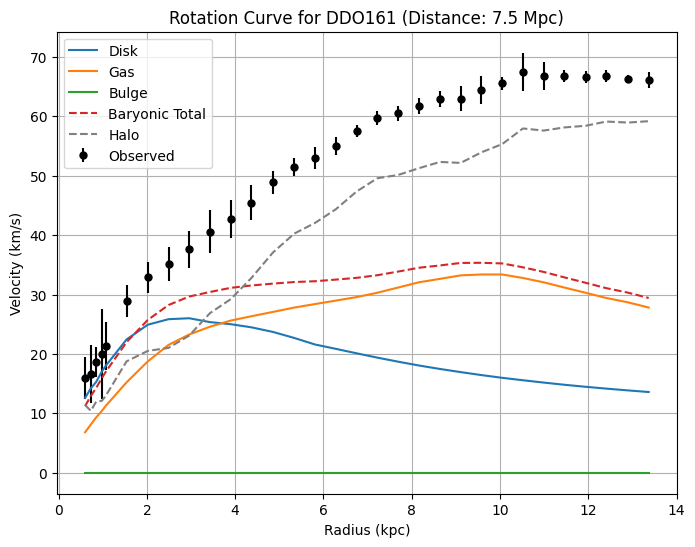

In [7]:
# plot the rotation curve and its components

SMTLdisk = 0.5  # example mass-to-light ratio for disk
SMTLbulge = 0.7  # example mass-to-light ratio for bulge

# total baryon component
Vbaryon = np.sqrt(SMTLdisk * df['Vdisk']**2 + SMTLbulge * df['Vbul']**2 + df['Vgas']**2)
# total dark matter component inferred 
Vhalo = np.sqrt(df['Vobs']**2 - Vbaryon**2)

# plotting 
plt.figure(figsize=(8,6))
plt.errorbar(df['Rad'], df['Vobs'], yerr=df['errV'], fmt='o', label='Observed', color='black', markersize=5)
plt.plot(df['Rad'], df['Vdisk'], label='Disk', color='C0')
plt.plot(df['Rad'], df['Vgas'], label='Gas', color='C1')
plt.plot(df['Rad'], df['Vbul'], label='Bulge', color='C2') 
plt.plot(df['Rad'], Vbaryon, label='Baryonic Total', color='C3', linestyle='--')
plt.plot(df['Rad'], Vhalo, label='Halo', color='grey', linestyle='--')


plt.xlabel(f"Radius ({units.at[0, 'Rad']})")
plt.ylabel(f"Velocity ({units.at[0, 'Vobs']})")
plt.title(f"Rotation Curve for DDO161 (Distance: {dist} Mpc)")
plt.legend()
plt.grid()
plt.show()

Notes:

From this point we would need to do the following:

1. Find the exact M/L ratio used to generate the baryons rotation curve 
2. The total mass of the halo -- possibly saved in meta data 
3. Derive an expression for the baryon potential from the rotation curve
4. Use mass and baryon potential as inputs to the jeans model to model the rotation curve 

# using the jeans model 

In [20]:
r1 = 20 # kpc
M200 = 1e11 # solar masses
c = 10 # concentration parameter

Phi_b = None # no baryons for now 

profile = jeans.squashed(r1, M200, c, Phi_b=Phi_b, verbose=True)

Begin spherically-symmetric relaxation with coarse grid (5 r points).
 Step 1: Start with DM-only solution and increase baryon fraction from 0 to 1.
  iteration 1: baryon fraction = 1.000000, was a success: True
 Step 2: Increase number of grid points using interpolated coarse-grid result as initial guess.
  iteration 2: number of grid points = 10, was a success: True
  iteration 3: number of grid points = 20, was a success: True
  iteration 4: number of grid points = 40, was a success: True
  iteration 5: number of grid points = 80, was a success: True
  iteration 6: number of grid points = 160, was a success: True
  iteration 7: number of grid points = 200, was a success: True
 Step 3: Continue relaxation until required tolerance 1e-08 achieved.
  iteration 8: was a success: True
End spherically-symmetric relaxation.



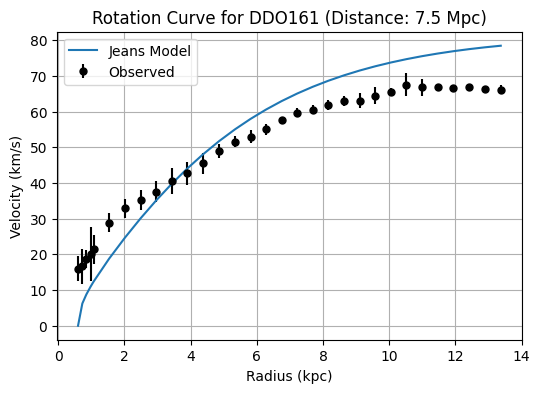

In [22]:
plt.figure(figsize=(6,4))
plt.errorbar(df['Rad'], df['Vobs'], yerr=df['errV'], fmt='o', label='Observed', color='black', markersize=5)
plt.plot(df['Rad'], profile.V(df['Rad'], Lmax=0), label='Jeans Model', color='C0')


plt.xlabel(f"Radius ({units.at[0, 'Rad']})")
plt.ylabel(f"Velocity ({units.at[0, 'Vobs']})")
plt.title(f"Rotation Curve for DDO161 (Distance: {dist} Mpc)")
plt.legend()
plt.grid()
plt.show()

Without the halo mass and baryons the fit will be poor, but this example illustrates how we will use the jeans model to fit the rotation curves. 